In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import LSTM, Dense, BatchNormalization, Softmax, Dropout, Bidirectional
import scipy.io  # to load MAT files
import time
import datetime
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import sys
import scipy.signal  # to downsample input data
%matplotlib inline
%load_ext tensorboard

print('Tf Keras:', keras.__version__)
print('TensorFlow:', tf.__version__)
print('GPU device:', tf.test.gpu_device_name())

if 'google.colab' in sys.modules:  # try to detect if we're running in colab or locally
  working_dir = '/content/drive/MyDrive/dataset'
else:
  working_dir = '.'

log_dir_base = working_dir + '/logs/fit'


def create_dataset(window, overlap, decimation_factor = 0, distrib_stat = 0):
  # Create the input and target data from PPG_ACC_dataset,
  # according to window and overlap
  dataset_dir = working_dir + '/PPG_ACC_dataset'
  subj_list = [1, 2, 3, 4, 5, 6, 7]  # 1-based
  x_data = np.empty((0, window, 4))
  y_data = np.empty((0, 1))  # labels

  # perturbations = adversarial_pattern(x_data, y_data)
  # x_data = x_data + perturbations * 0.1


  subj_inputs = []  # number of inputs for every subject
  print('### creating dataset')
  # load data from PPG_ACC_dataset and reshape for RNN
  tot_rows = 0
  for subject in subj_list:
    subj_inputs.append(0)
    for category, name in enumerate(('rest', 'squat', 'step')):
      for record in range(0, 5):
        acc = scipy.io.loadmat(f'{dataset_dir}/S{subject}/{name}{record + 1}_acc.mat')['ACC']
        ppg = scipy.io.loadmat(f'{dataset_dir}/S{subject}/{name}{record + 1}_ppg.mat')['PPG'][:, 0:2]  # some PPG files have 3 columns instead of 2
        fusion = np.hstack((acc[:, 1:], ppg[:, 1:]))  # remove x axis (time)
        tot_rows += len(fusion)
        clean_data(fusion)
        # decimation (optional)
        if decimation_factor:
          fusion2 = np.empty((fusion.shape[0] // decimation_factor, fusion.shape[1]))
          for col in range(0, 4):
            #tmp = scipy.signal.decimate(fusion[:, col], decimation_factor)
            tmp = fusion[:, col][::decimation_factor]  # simpler method
            fusion2[:, col] = tmp[:len(fusion2)]
          fusion = fusion2
        # windowing
        # compute number of windows (lazy way)
        i = 0
        num_w = 0
        while i + window  <= len(fusion):
          i += (window - overlap)
          num_w += 1
        # compute actual windows
        x_data_part = np.empty((num_w, window, 4))  # preallocate
        i = 0
        for w in range(0, num_w):
          x_data_part[w] = fusion[i:i + window]
          i += (window - overlap)
        x_data = np.vstack((x_data, x_data_part))
        y_data = np.vstack((y_data, np.full((num_w, 1), category)))
        subj_inputs[-1] += num_w

  # normalize single windows
  for w in x_data:
    # remove mean value from ACC
    w[:, 0] -= np.mean(w[:, 0])  # acc 1
    w[:, 1] -= np.mean(w[:, 1])  # acc 2
    w[:, 2] -= np.mean(w[:, 2])  # acc 3
    # standardize PPG
    w[:, 3] = StandardScaler().fit_transform(w[:, 3].reshape(-1, 1)).reshape((w.shape[0],))  # PPG

  print('tot samples:', tot_rows)
  print('x_data:', x_data.shape)
  print('y_data:', y_data.shape)
  print('inputs per subject:', subj_inputs)
  if distrib_stat:
    n = sum(subj_inputs[:distrib_stat])
    print('class distribution (first', distrib_stat, 'subjects):', np.sum(y_data[:n] == 0), np.sum(y_data[:n] == 1), np.sum(y_data[:n] == 2))
  return x_data, y_data, subj_inputs


def clean_data(fusion):
  # some tracks have isolated NaNs
  for col in range(0, 4):
    ids = np.where(np.isnan(fusion[:, col]))[0]
    for row in ids:
      fusion[row, col] = 0.5 * (fusion[row - 1, col] + fusion[row + 1, col])
  # some PPG tracks have periodic, isolated zeros, resulting in spikes
  for col in range(3, 4):
    ids = np.where(fusion[:, col] == 0)[0]
    for row in ids:
      fusion[row, col] = 0.5 * (fusion[row - 1, col] + fusion[row + 1, col])
  # many acc. tracks have periodic, single-point spikes of no specific values. Let's test all of them, even if it's slow
  for col in range(0, 3):
    for row in range(1, len(fusion) - 1):
      if abs(fusion[row, col] - fusion[row - 1, col]) > 5000 and abs(fusion[row, col] - fusion[row + 1, col]) > 5000:
        fusion[row, col] = 0.5 * (fusion[row - 1, col] + fusion[row + 1, col])


def partition_data(subjects):
  # subjects = tuple (0-based)
  x_part = None
  y_part = None
  for subj in subjects:
    skip = sum(subj_inputs[:subj])
    num = subj_inputs[subj]
    xx = x_data[skip : skip + num]
    yy = y_data[skip : skip + num]
    if x_part is None:
      x_part = xx.copy()
      y_part = yy.copy()
    else:
      x_part = np.vstack((x_part, xx))  # vstack creates a copy of the data
      y_part = np.vstack((y_part, yy))
  return x_part, y_part


def oversampling(x_data, y_data, subj_inputs, num_subjects):
  # Duplicate inputs with classes occurring less, so to have a more balanced distribution.
  # We want to do that on a per-subject basis, so to keep subjects separate.
  # Moreover, we do that only to the first num_subjects subjects, so to leave test subjects unaltered.
  x_data_over = None
  y_data_over = None
  subj_inputs_over = []
  skip = 0
  for subj_num in subj_inputs[:num_subjects]:
    x_part = x_data[skip : skip + subj_num]
    y_part = y_data[skip : skip + subj_num]
    occurr = (np.sum(y_part == 0), np.sum(y_part == 1), np.sum(y_part == 2))
    assert(occurr[0] == max(occurr))
    mul = (1, occurr[0] // occurr[1], occurr[0] // occurr[2])
    for cl in (1, 2):
      mask = y_part[:, 0] == cl
      x_dup = x_part[mask].copy()
      y_dup = y_part[mask].copy()
      for n in range(0, mul[cl] - 1):
        x_part = np.vstack((x_part, x_dup))
        y_part = np.vstack((y_part, y_dup))
    if x_data_over is None:
      x_data_over = x_part
      y_data_over = y_part
    else:
      x_data_over = np.vstack((x_data_over, x_part))
      y_data_over = np.vstack((y_data_over, y_part))
    subj_inputs_over.append(len(x_part))
    skip += subj_num
  x_data_over = np.vstack((x_data_over, x_data[skip:]))  # subjects not oversampled
  y_data_over = np.vstack((y_data_over, y_data[skip:]))
  subj_inputs_over.extend(subj_inputs[num_subjects:])
  print('After oversampling', num_subjects, 'subjects:')
  print('x_data:', x_data_over.shape)
  print('y_data:', y_data_over.shape)
  print('inputs per subject:', subj_inputs_over)
  n = sum(subj_inputs_over[:num_subjects])
  print('class distribution (first', num_subjects, 'subjects):', np.sum(y_data_over[:n] == 0), np.sum(y_data_over[:n] == 1), np.sum(y_data_over[:n] == 2))
  return x_data_over, y_data_over, subj_inputs_over


def create_model(window, dense1, lstm1, lstm2, lstm3 = 0, dropout = 0.2):
  print("### creating model")
  model = keras.Sequential()
  model.add(keras.Input(shape = (window, 4)))
  if dense1: model.add(Dense(dense1, name = 'dense1'))
  model.add(BatchNormalization(name = 'norm'))
  #model.add(Dropout(dropout, name = 'drop1'))
  model.add(LSTM(lstm1, return_sequences = bool(lstm2), name = 'lstm1'))
  if lstm2:
    model.add(Dropout(dropout, name = 'drop2'))
    model.add(LSTM(lstm2, return_sequences = bool(lstm3), name = 'lstm2'))
  if lstm3:
    model.add(Dropout(dropout, name = 'drop3'))
    model.add(LSTM(lstm3, name = 'lstm3'))
  model.add(Dropout(dropout, name = 'drop4'))
  model.add(Dense(3, name = 'dense2'))
  model.compile(loss = keras.losses.SparseCategoricalCrossentropy(from_logits = True),
    optimizer = 'adam', metrics = ['accuracy'])
  model.summary()
  return model

Tf Keras: 2.11.0
TensorFlow: 2.11.0
GPU device: /device:GPU:0


In [3]:
def train_session(save_model = True, load_model = None, write_report = True, file_id = ''):

  def write_values():
    print(time.strftime('%H:%M:%S'), file = out_f)
    print('window', window, 'overlap', overlap, 'decimation', decimation, file = out_f)
    print('layers', dense1, lstm1, lstm2, lstm3, file = out_f)
    print('oversample', oversample, file = out_f)
    print('subj_train', permutation, file = out_f)
    print('epochs', epochs, file = out_f)
    if history is not None:
      print('fit_accuracy', [round(x, 4) for x in history.history['accuracy']], file = out_f)
    if history is not None and 'val_accuracy' in history.history:
      print('fit_val_accuracy', [round(x, 4) for x in history.history['val_accuracy']], file = out_f)
    print('subj_test', subjs_test, file = out_f)
    print('test_accuracy', round(eval_metrics[1], 4), file = out_f)
    print('permutation', perm_index + 1, file = out_f)
    # print('iteration', iter + 1, file = out_f)
    print('time_train', time_train, file = out_f)
    print('time_test', time_test, file = out_f)
    print(file = out_f)
    out_f.flush()

  if write_report:
    output_file = time.strftime('%Y%m%d-%H%M%S') + '.txt'
    out_f = open(working_dir + '/' + output_file, 'w')
  # tensorboard stuff
  #%rm -rf "$log_dir_base"
  log_dir = log_dir_base + '/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
  for perm_index, permutation in enumerate(subjs_train_perm):
    assert(type(permutation) == tuple)
    assert(len(permutation) == 2)
    assert(type(permutation[0]) == tuple)
    assert(type(permutation[1]) == tuple)
    assert(type(subjs_test) == tuple)
    
    if load_model is None:
      model = create_model(window, dense1, lstm1, lstm2, lstm3)
      # model training
      x_data_train, y_data_train = partition_data(permutation[0])  # train subjects

      print("Mean: ", np.mean(x_data_train[:,:, 3]))
      print("Deviation: ", np.std(x_data_train[:,:, 3]))

      x_data_val, y_data_val = partition_data(permutation[1])  # validation subjects, can be None
      print(f'### training with {len(x_data_train)} inputs, {len(x_data_val) if x_data_val is not None else 0} validation')
      tensorboard_callback = keras.callbacks.TensorBoard(log_dir + f'_{perm_index + 1}_{1}', histogram_freq = 1)
      # train
      start_time = time.monotonic()
      history = model.fit(x_data_train, y_data_train, epochs = epochs,
        validation_data = (x_data_val, y_data_val) if x_data_val is not None else None,
        callbacks = [tensorboard_callback])
      time_train = time.monotonic() - start_time
    else:
      # model must match with dataset parameters
      model = keras.models.load_model(load_model)
      history = None
      time_train = 0

    # model test
    x_data_test, y_data_test = partition_data(subjs_test)
    print(f'### testing with {len(x_data_test)} inputs')
    start_time = time.monotonic()
    eval_metrics = model.evaluate(x_data_test, y_data_test)
    time_test = time.monotonic() - start_time
    if write_report:
      write_values()
    if save_model:
      # save in both directory and h5 formats (we had problems with both of them sometimes)
      model_file_name = f'{working_dir}/{file_id}model_w{window:04d}_o{overlap:03d}_d{decimation:03d}_e{epochs}_t{round(eval_metrics[1] * 10000)}'
      #model.save(model_file_name)
      model.save(model_file_name + '.h5')

  if write_report:
    out_f.close()

In [4]:
# create dataset with given window and overlap
if __name__ == '__main__':
  window = 1200
  overlap = window // 2
  oversample = False
  decimation = 0
  if decimation:
    window //= decimation
    overlap //= decimation
  x_data, y_data, subj_inputs = create_dataset(window, overlap, decimation, distrib_stat = 5)
  if oversample:
    x_data, y_data, subj_inputs = oversampling(x_data, y_data, subj_inputs, 5)

### creating dataset
tot samples: 6880418
x_data: (11310, 1200, 4)
y_data: (11310, 1)
inputs per subject: [2663, 2364, 1193, 1205, 1264, 1288, 1333]
class distribution (first 5 subjects): 6871 773 1045


In [5]:
# create and train model
if __name__ == '__main__':
  dense1 = 8
  lstm1 = 8
  lstm2 = 8
  lstm3 = 8
  # subjs_train_perm = ( ((0, 1, 2, 3, 4), ()), )  # final model
  subjs_train_perm = ( ((0, 1, 2), ()), )  # final model
  #subjs_train_perm = ( ((0, 1, 2, 3), (4,)), ((0, 1, 2, 4), (3,)), ((0, 1, 3, 4), (2,)), ((0, 2, 3, 4), (1,)), ((1, 2, 3, 4), (0,)) )  # cross-validation
  subjs_test = (5, 6)
  epochs = 100
  iterations = 1  # repeat every test to cope with randomness
  train_session()

### creating model
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense1 (Dense)              (None, 1200, 8)           40        
                                                                 
 norm (BatchNormalization)   (None, 1200, 8)           32        
                                                                 
 lstm1 (LSTM)                (None, 1200, 8)           544       
                                                                 
 drop2 (Dropout)             (None, 1200, 8)           0         
                                                                 
 lstm2 (LSTM)                (None, 1200, 8)           544       
                                                                 
 drop3 (Dropout)             (None, 1200, 8)           0         
                                                                 
 lstm3 (LSTM)                (None, 8

In [6]:
# model test only
model = tf.keras.models.load_model('/content/drive/MyDrive/dataset/epo5_eps0.5.h5')

if __name__ == '__main__':
  x_data_test, y_data_test = partition_data(subjs_test)
  print(f'### testing with {len(x_data_test)} inputs')
  eval_metrics = model.evaluate(x_data_test, y_data_test)

### testing with 2621 inputs
82/82 [==============================] - 4s 35ms/step - loss: 0.4578 - accuracy: 0.7959


82/82 [==============================] - 4s 34ms/step


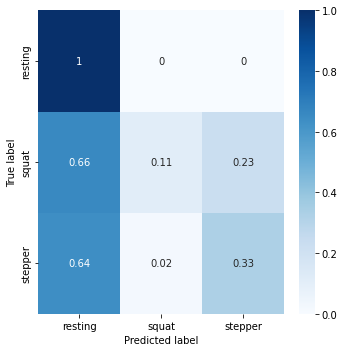

In [7]:
# create confusion matrix
if __name__ == '__main__':
  import pandas as pd
  import seaborn
  # y_pred = pretrained_model.predict_classes(x_data_test)
  y_prob = model.predict(x_data_test) 
  y_pred = y_prob.argmax(axis=-1)
  con_mat = tf.math.confusion_matrix(labels = y_data_test, predictions = y_pred).numpy()
  con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis = 1)[:, np.newaxis], decimals = 2)
  classes = ['resting', 'squat', 'stepper']
  con_mat_df = pd.DataFrame(con_mat_norm, index = classes, columns = classes)
  #con_mat_df['squat']['stepper']=0.11  # fix sum not 1 due to rounding
  #print(con_mat_df)
  figure = plt.figure(figsize = (5, 5))
  seaborn.heatmap(con_mat_df, annot = True, cmap = plt.cm.Blues)
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.tight_layout()
  plt.savefig(working_dir + '/confusion_matrix.eps', format='eps')
  plt.show()

Adversarial part

In [8]:
def adversarial_pattern(image, label, model):
    # gpu_options = tf.compat.v1.GPUOptions(allow_growth=True)
    # session = tf.compat.v1.InteractiveSession(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))
    
    image = tf.cast(image, tf.float32)
    
    with tf.GradientTape() as tape:
        tape.watch(image)
        prediction = model(image)
        loss = tf.keras.losses.MSE(label, prediction)
    
    gradient = tape.gradient(loss, image)
    
    signed_grad = tf.sign(gradient)
    
    return signed_grad

In [9]:
def adversarial_attack(save_model = True, load_model = None, write_report = True, file_id = ''):

  def write_values():
    print(time.strftime('%H:%M:%S'), file = out_f)
    print('window', window, 'overlap', overlap, 'decimation', decimation, file = out_f)
    print('layers', dense1, lstm1, lstm2, lstm3, file = out_f)
    print('oversample', oversample, file = out_f)
    print('subj_train', permutation, file = out_f)
    print('epochs', epochs, file = out_f)
    if history is not None:
      print('fit_accuracy', [round(x, 4) for x in history.history['accuracy']], file = out_f)
    if history is not None and 'val_accuracy' in history.history:
      print('fit_val_accuracy', [round(x, 4) for x in history.history['val_accuracy']], file = out_f)
    print('subj_test', subjs_test, file = out_f)
    print('test_accuracy', round(eval_metrics[1], 4), file = out_f)
    print('permutation', perm_index + 1, file = out_f)
    # print('iteration', iter + 1, file = out_f)
    print('time_train', time_train, file = out_f)
    print('time_test', time_test, file = out_f)
    print(file = out_f)
    out_f.flush()

  if write_report:
    output_file = time.strftime('%Y%m%d-%H%M%S') + '.txt'
    out_f = open(working_dir + '/' + output_file, 'w')
  # tensorboard stuff
  #%rm -rf "$log_dir_base"
  log_dir = log_dir_base + '/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
  for perm_index, permutation in enumerate(subjs_train_perm):
    assert(type(permutation) == tuple)
    assert(len(permutation) == 2)
    assert(type(permutation[0]) == tuple)
    assert(type(permutation[1]) == tuple)
    assert(type(subjs_test) == tuple)
    
    if load_model is None:
      model = create_model(window, dense1, lstm1, lstm2, lstm3)
      # model training
      x_data_train, y_data_train = partition_data(permutation[0])  # train subjects

      perturbations = adversarial_pattern(x_data_train, y_data_train, model)
      adversarial = x_data_train + perturbations * 0.5

      print("Mean: ", np.mean(adversarial[:,:, 3]))
      print("Deviation: ", np.std(adversarial[:,:, 3]))      

      x_data_val, y_data_val = partition_data(permutation[1])  # validation subjects, can be None
      print(f'### training with {len(adversarial)} inputs, {len(x_data_val) if x_data_val is not None else 0} validation')
      tensorboard_callback = keras.callbacks.TensorBoard(log_dir + f'_{perm_index + 1}_{1}', histogram_freq = 1)
      # train
      start_time = time.monotonic()
      history = model.fit(adversarial, y_data_train, epochs = epochs,
        validation_data = (x_data_val, y_data_val) if x_data_val is not None else None,
        callbacks = [tensorboard_callback])
      time_train = time.monotonic() - start_time
    else:
      # model must match with dataset parameters
      model = keras.models.load_model(load_model)
      history = None
      time_train = 0

    # model test
    x_data_test, y_data_test = partition_data(subjs_test)
    print(f'### testing with {len(x_data_test)} inputs')
    start_time = time.monotonic()
    eval_metrics = model.evaluate(x_data_test, y_data_test)
    time_test = time.monotonic() - start_time
    if write_report:
      write_values()
    if save_model:
      # save in both directory and h5 formats (we had problems with both of them sometimes)
      model_file_name = f'{working_dir}/{file_id}model_w{window:04d}_o{overlap:03d}_d{decimation:03d}_e{epochs}_t{round(eval_metrics[1] * 10000)}'
      #model.save(model_file_name)
      model.save(model_file_name + '.h5')

  if write_report:
    out_f.close()

In [10]:
# create and train model
if __name__ == '__main__':
  dense1 = 8
  lstm1 = 8
  lstm2 = 8
  lstm3 = 8
  # subjs_train_perm = ( ((0, 1, 2, 3, 4), ()), )  # final model
  subjs_train_perm = ( ((0, 1, 2), ()), )  # final model
  #subjs_train_perm = ( ((0, 1, 2, 3), (4,)), ((0, 1, 2, 4), (3,)), ((0, 1, 3, 4), (2,)), ((0, 2, 3, 4), (1,)), ((1, 2, 3, 4), (0,)) )  # cross-validation
  subjs_test = (5, 6)
  epochs = 5
  iterations = 1  # repeat every test to cope with randomness
  adversarial_attack()

### creating model
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense1 (Dense)              (None, 1200, 8)           40        
                                                                 
 norm (BatchNormalization)   (None, 1200, 8)           32        
                                                                 
 lstm1 (LSTM)                (None, 1200, 8)           544       
                                                                 
 drop2 (Dropout)             (None, 1200, 8)           0         
                                                                 
 lstm2 (LSTM)                (None, 1200, 8)           544       
                                                                 
 drop3 (Dropout)             (None, 1200, 8)           0         
                                                                 
 lstm3 (LSTM)                (None,

In [11]:
# model test only
attacked_model = tf.keras.models.load_model('/content/drive/MyDrive/dataset/epo5_eps0.5.h5')

if __name__ == '__main__':
  x_test, y_test = partition_data(subjs_test)
  print(f'### testing with {len(x_test)} inputs')
  eval_metrics = attacked_model.evaluate(x_test, y_test)

### testing with 2621 inputs
82/82 [==============================] - 5s 47ms/step - loss: 0.4578 - accuracy: 0.7959


82/82 [==============================] - 4s 33ms/step


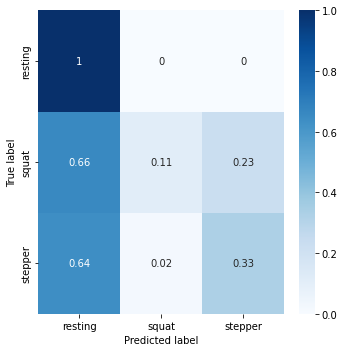

In [12]:
# create confusion matrix
if __name__ == '__main__':
  import pandas as pd
  import seaborn
  # y_pred = pretrained_model.predict_classes(x_data_test)
  y_prob = attacked_model.predict(x_test) 
  y_pred = y_prob.argmax(axis=-1)
  con_mat = tf.math.confusion_matrix(labels = y_test, predictions = y_pred).numpy()
  con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis = 1)[:, np.newaxis], decimals = 2)
  classes = ['resting', 'squat', 'stepper']
  con_mat_df = pd.DataFrame(con_mat_norm, index = classes, columns = classes)
  #con_mat_df['squat']['stepper']=0.11  # fix sum not 1 due to rounding
  #print(con_mat_df)
  figure = plt.figure(figsize = (5, 5))
  seaborn.heatmap(con_mat_df, annot = True, cmap = plt.cm.Blues)
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.tight_layout()
  plt.savefig(working_dir + '/confusion_matrix.eps', format='eps')
  plt.show()